In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn.modules import dropout
import torch.nn.functional as F
import torch.optim as optim 
import optuna
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, TensorDataset
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import json
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import joblib
from multiprocessing import Pool

In [2]:
jsonFile = "/Users/isaackante/Downloads/pvs_2021-03-02_to_2022-11-30.csv"

with open(jsonFile, 'r') as fileData:
    jsonData = json.load(fileData)

fullDF = pd.DataFrame(jsonData)
print(f"Dataframe length: {len(fullDF)}")

Dataframe length: 1697935


In [3]:
fullDF

,XCOR:LTUS:118:BACT,XCOR:LTUS:148:BACT,XCOR:LTUS:228:BACT,XCOR:LTUS:296:BACT,XCOR:LTUS:368:BACT,XCOR:LTUS:448:BACT,XCOR:LTUS:508:BACT,XCOR:LTUS:548:BACT,XCOR:LTUS:568:BACT,XCOR:LTUS:616:BACT,...,BPMS:LTUS:620:Y1H,BPMS:LTUS:640:Y1H,BPMS:LTUS:660:Y1H,BPMS:LTUS:680:Y1H,BPMS:LTUS:740:Y1H,BPMS:LTUS:750:Y1H,BPMS:LTUS:820:Y1H,BPMS:LTUS:840:Y1H,BPMS:LTUS:860:Y1H,BPMS:LTUS:880:Y1H
1614686781000,-0.005894,0.010674,0.015187,0.003056,0.020692,-0.000383,0.010843,-0.011724,0.007895,0.003348,...,0.081574,-0.388519,0.024542,0.123215,0.255312,-0.029176,-0.754132,-0.920574,-1.065490,-1.381211
1614686792000,-0.005894,0.010675,0.015186,0.003055,0.020692,-0.000383,0.010731,-0.011777,0.007895,0.003347,...,0.069327,-0.424184,0.009931,0.113676,0.264643,-0.012710,-0.739264,-0.908223,-1.051875,-1.367935
1614686793000,-0.005894,0.010675,0.015186,0.003055,0.020691,-0.000383,0.010739,-0.011672,0.007896,0.003348,...,0.092214,-0.371535,0.029579,0.125250,0.249571,-0.043525,-0.757154,-0.919364,-1.068223,-1.380300
1614686794000,-0.005894,0.010675,0.015186,0.003056,0.020693,-0.000382,0.010748,-0.011836,0.007896,0.003348,...,0.085862,-0.382025,0.028701,0.125641,0.254153,-0.041541,-0.763009,-0.927409,-1.072004,-1.390729
1614686795000,-0.005894,0.010674,0.015186,0.003056,0.020694,-0.000383,0.010756,-0.011695,0.007895,0.003349,...,0.086317,-0.377257,0.030934,0.126694,0.255299,-0.035130,-0.771315,-0.937547,-1.083597,-1.400562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668755362000,-0.006696,0.007762,0.012248,0.019892,0.018911,-0.000121,0.010442,0.001622,0.000568,0.010471,...,0.261482,0.316519,0.410203,0.453788,0.292541,-0.555982,0.242697,0.125239,0.083574,-0.184363
1668755363000,-0.006695,0.007763,0.012248,0.019891,0.018910,-0.000119,0.010452,0.001470,0.000567,0.010471,...,0.254319,0.291053,0.390684,0.438549,0.295928,-0.526931,0.269874,0.157057,0.104409,-0.160754
1668755364000,-0.006694,0.007763,0.012248,0.019891,0.018910,-0.000120,0.010462,0.001297,0.000568,0.010472,...,0.263715,0.309573,0.410216,0.453933,0.281019,-0.561139,0.242024,0.129347,0.089619,-0.174837
1668755365000,-0.006695,0.007762,0.012248,0.019892,0.018910,-0.000120,0.010472,0.001285,0.000567,0.010471,...,0.270974,0.354164,0.423908,0.476336,0.239657,-0.599715,0.199322,0.093584,0.070586,-0.201175


In [4]:
num_rows = fullDF.shape[0]
num_rows

1697935

In [7]:
inputPvs = [ "XCOR:LTUS:118:BACT", "XCOR:LTUS:148:BACT", "XCOR:LTUS:228:BACT", "XCOR:LTUS:296:BACT", "XCOR:LTUS:368:BACT", "XCOR:LTUS:448:BACT", "XCOR:LTUS:508:BACT", "XCOR:LTUS:548:BACT", "XCOR:LTUS:568:BACT", "XCOR:LTUS:616:BACT", "XCOR:LTUS:658:BACT", "XCOR:LTUS:718:BACT", "XCOR:LTUS:722:BACT", "XCOR:LTUS:738:BACT", "XCOR:LTUS:758:BACT", "XCOR:LTUS:768:BACT", "XCOR:LTUS:826:BACT", "XCOR:LTUS:858:BACT", "YCOR:LTUS:111:BACT", "YCOR:LTUS:183:BACT", "YCOR:LTUS:267:BACT", "YCOR:LTUS:341:BACT", "YCOR:LTUS:427:BACT", "YCOR:LTUS:471:BACT", "YCOR:LTUS:499:BACT", "YCOR:LTUS:547:BACT", "YCOR:LTUS:561:BACT", "YCOR:LTUS:577:BACT", "YCOR:LTUS:641:BACT", "YCOR:LTUS:677:BACT", "YCOR:LTUS:721:BACT", "YCOR:LTUS:729:BACT", "YCOR:LTUS:749:BACT", "YCOR:LTUS:767:BACT", "YCOR:LTUS:777:BACT", "YCOR:LTUS:839:BACT", "YCOR:LTUS:877:BACT", "QUAD:LTUS:110:BACT", "QUAD:LTUS:120:BACT", "QUAD:LTUS:150:BACT", "QUAD:LTUS:180:BACT", "QUAD:LTUS:235:BACT", "QUAD:LTUS:270:BACT", "QUAD:LTUS:300:BACT", "QUAD:LTUS:345:BACT", "QUAD:LTUS:370:BACT", "QUAD:LTUS:430:BACT", "QUAD:LTUS:450:BACT", "QUAD:LTUS:470:BACT", "QUAD:LTUS:500:BACT", "QUAD:LTUS:510:BACT", "QUAD:LTUS:540:BACT", "QUAD:LTUS:550:BACT", "QUAD:LTUS:560:BACT", "QUAD:LTUS:570:BACT", "QUAD:LTUS:580:BACT", "QUAD:LTUS:620:BACT", "QUAD:LTUS:640:BACT", "QUAD:LTUS:660:BACT", "QUAD:LTUS:665:BACT", "QUAD:LTUS:680:BACT", "QUAD:LTUS:720:BACT", "QUAD:LTUS:725:BACT", "QUAD:LTUS:730:BACT", "QUAD:LTUS:740:BACT", "QUAD:LTUS:750:BACT", "QUAD:LTUS:760:BACT", "QUAD:LTUS:772:BACT", "QUAD:LTUS:780:BACT", "QUAD:LTUS:820:BACT", "QUAD:LTUS:840:BACT", "QUAD:LTUS:860:BACT", "QUAD:LTUS:880:BACT"]
outputPvs = ['BPMS:LTUS:120:X1H', 'BPMS:LTUS:150:X1H', 'BPMS:LTUS:180:X1H', 'BPMS:LTUS:235:X1H', 'BPMS:LTUS:300:X1H', 'BPMS:LTUS:345:X1H', 'BPMS:LTUS:370:X1H', 'BPMS:LTUS:450:X1H', 'BPMS:LTUS:470:X1H', 'BPMS:LTUS:500:X1H', 'BPMS:LTUS:510:X1H', 'BPMS:LTUS:540:X1H', 'BPMS:LTUS:560:X1H', 'BPMS:LTUS:570:X1H', 'BPMS:LTUS:580:X1H', 'BPMS:LTUS:620:X1H', 'BPMS:LTUS:640:X1H', 'BPMS:LTUS:660:X1H', 'BPMS:LTUS:680:X1H', 'BPMS:LTUS:740:X1H', 'BPMS:LTUS:750:X1H', 'BPMS:LTUS:820:X1H', 'BPMS:LTUS:840:X1H', 'BPMS:LTUS:860:X1H', 'BPMS:LTUS:880:X1H', 'BPMS:LTUS:120:Y1H', 'BPMS:LTUS:150:Y1H', 'BPMS:LTUS:180:Y1H', 'BPMS:LTUS:235:Y1H', 'BPMS:LTUS:300:Y1H', 'BPMS:LTUS:345:Y1H', 'BPMS:LTUS:370:Y1H', 'BPMS:LTUS:450:Y1H', 'BPMS:LTUS:470:Y1H', 'BPMS:LTUS:500:Y1H', 'BPMS:LTUS:510:Y1H', 'BPMS:LTUS:540:Y1H', 'BPMS:LTUS:560:Y1H', 'BPMS:LTUS:570:Y1H', 'BPMS:LTUS:580:Y1H', 'BPMS:LTUS:620:Y1H', 'BPMS:LTUS:640:Y1H', 'BPMS:LTUS:660:Y1H', 'BPMS:LTUS:680:Y1H', 'BPMS:LTUS:740:Y1H', 'BPMS:LTUS:750:Y1H', 'BPMS:LTUS:820:Y1H', 'BPMS:LTUS:840:Y1H', 'BPMS:LTUS:860:Y1H', 'BPMS:LTUS:880:Y1H']
print("Input PVs:",len(inputPvs))
print("Output PVs:",len(outputPvs))

Input PVs: 73
Output PVs: 50


## Seperate input and output into dataframes

In [8]:
input_df = fullDF[inputPvs]
# input_df
input_df = input_df.to_numpy()
# input_df
inputscaler = MinMaxScaler()
input_df = inputscaler.fit_transform(input_df)
input_df.shape
# input_df

(1697935, 73)

In [9]:
output_df = fullDF[outputPvs]
# output_df

## Create Custom Scaler for output df

In [10]:
def custom_scale_dataframe(df, column_limits):
    scaled_df = df.copy()
    
    for column, (min_limit, max_limit) in column_limits.items():
        if column in df.columns:
            scaled_df[column] = (df[column] - min_limit) / (max_limit - min_limit)
    
    return scaled_df

In [11]:
column_limits = {
    'BPMS_LTUS_120_X1H': (-4.827219, 4.117475),
    'BPMS_LTUS_150_X1H': (-4.670366, 4.160087),
    'BPMS_LTUS_180_X1H': (-1.61531, 0.580029),
    'BPMS_LTUS_235_X1H': (-4.827219, 3.323006),
    'BPMS_LTUS_300_X1H': (-4.670366, 1.356171),
    'BPMS_LTUS_345_X1H': (-1.33319, 0.918294),
    'BPMS_LTUS_370_X1H': (-1.708888, 4.117475),
    'BPMS_LTUS_450_X1H': (-4.641845, 0.346073),
    'BPMS_LTUS_470_X1H': (-0.996765, 1.353984),
    'BPMS_LTUS_500_X1H': (-2.395545, 2.80548),
    'BPMS_LTUS_510_X1H': (-3.538317, 4.160087),
    'BPMS_LTUS_540_X1H': (-0.610118, 0.580029),
    'BPMS_LTUS_560_X1H': (-0.73015, 0.531605),
    'BPMS_LTUS_570_X1H': (-0.458181, 1.382308),
    'BPMS_LTUS_580_X1H': (-0.618446, 0.356522),
    'BPMS_LTUS_620_X1H': (-0.547083, 1.28978),
    'BPMS_LTUS_640_X1H': (-0.635806, 0.298985),
    'BPMS_LTUS_660_X1H': (-0.890536, 0.201593),
    'BPMS_LTUS_680_X1H': (-0.472103, 0.628052),
    'BPMS_LTUS_740_X1H': (-1.45062, 1.242294),
    'BPMS_LTUS_750_X1H': (-0.681022, 0.951346),
    'BPMS_LTUS_820_X1H': (-0.99279, 0.945927),
    'BPMS_LTUS_840_X1H': (-1.011758, 0.687809),
    'BPMS_LTUS_860_X1H': (-1.162863, 0.815839),
    'BPMS_LTUS_880_X1H': (-0.907198, 0.806334),
    'BPMS_LTUS_120_Y1H': (-1.96247, 2.150131),
    'BPMS_LTUS_150_Y1H': (-1.076272, 1.588754),
    'BPMS_LTUS_180_Y1H': (-1.329813, 0.167812),
    'BPMS_LTUS_235_Y1H': (-0.362183, 3.323006),
    'BPMS_LTUS_300_Y1H': (-2.537684, 0.00258),
    'BPMS_LTUS_345_Y1H': (-1.283295, 2.037522),
    'BPMS_LTUS_370_Y1H': (-0.654882, 1.560715),
    'BPMS_LTUS_450_Y1H': (-0.914182, 1.466992),
    'BPMS_LTUS_470_Y1H': (-1.96247, 1.018785),
    'BPMS_LTUS_500_Y1H': (-1.331524, 2.80548),
    'BPMS_LTUS_510_Y1H': (-0.871627, 4.160087),
    'BPMS_LTUS_540_Y1H': (-1.922738, 0.580029),
    'BPMS_LTUS_560_Y1H': (-2.229401, 0.531605),
    'BPMS_LTUS_570_Y1H': (-0.779045, 1.382308),
    'BPMS_LTUS_580_Y1H': (-0.981595, 0.356522),
    'BPMS_LTUS_620_Y1H': (-0.4033, 1.28978),
    'BPMS_LTUS_640_Y1H': (-0.987313, 0.298985),
    'BPMS_LTUS_660_Y1H': (-0.703766, 0.201593),
    'BPMS_LTUS_680_Y1H': (-0.472103, 0.628052),
    'BPMS_LTUS_740_Y1H': (-0.542543, 1.242294),
    'BPMS_LTUS_750_Y1H': (-1.090887, 0.951346),
    'BPMS_LTUS_820_Y1H': (-0.822775, 0.945927),
    'BPMS_LTUS_840_Y1H': (-0.979512, 0.687809),
    'BPMS_LTUS_860_Y1H': (-1.107637, 0.815839),
    'BPMS_LTUS_880_Y1H': (-1.414454, 0.806334)
}

In [13]:
len(output_df.columns), len(column_limits)

(50, 50)

In [14]:
data = output_df

In [15]:
for column, (min_limit, max_limit) in column_limits.items():
        print(column, min_limit, max_limit)

BPMS_LTUS_120_X1H -4.827219 4.117475
BPMS_LTUS_150_X1H -4.670366 4.160087
BPMS_LTUS_180_X1H -1.61531 0.580029
BPMS_LTUS_235_X1H -4.827219 3.323006
BPMS_LTUS_300_X1H -4.670366 1.356171
BPMS_LTUS_345_X1H -1.33319 0.918294
BPMS_LTUS_370_X1H -1.708888 4.117475
BPMS_LTUS_450_X1H -4.641845 0.346073
BPMS_LTUS_470_X1H -0.996765 1.353984
BPMS_LTUS_500_X1H -2.395545 2.80548
BPMS_LTUS_510_X1H -3.538317 4.160087
BPMS_LTUS_540_X1H -0.610118 0.580029
BPMS_LTUS_560_X1H -0.73015 0.531605
BPMS_LTUS_570_X1H -0.458181 1.382308
BPMS_LTUS_580_X1H -0.618446 0.356522
BPMS_LTUS_620_X1H -0.547083 1.28978
BPMS_LTUS_640_X1H -0.635806 0.298985
BPMS_LTUS_660_X1H -0.890536 0.201593
BPMS_LTUS_680_X1H -0.472103 0.628052
BPMS_LTUS_740_X1H -1.45062 1.242294
BPMS_LTUS_750_X1H -0.681022 0.951346
BPMS_LTUS_820_X1H -0.99279 0.945927
BPMS_LTUS_840_X1H -1.011758 0.687809
BPMS_LTUS_860_X1H -1.162863 0.815839
BPMS_LTUS_880_X1H -0.907198 0.806334
BPMS_LTUS_120_Y1H -1.96247 2.150131
BPMS_LTUS_150_Y1H -1.076272 1.588754
BPMS_LTUS

In [16]:
df = pd.DataFrame(data)

In [17]:
scaled_df = custom_scale_dataframe(df, column_limits)
scaled_df.head()

,BPMS:LTUS:120:X1H,BPMS:LTUS:150:X1H,BPMS:LTUS:180:X1H,BPMS:LTUS:235:X1H,BPMS:LTUS:300:X1H,BPMS:LTUS:345:X1H,BPMS:LTUS:370:X1H,BPMS:LTUS:450:X1H,BPMS:LTUS:470:X1H,BPMS:LTUS:500:X1H,...,BPMS:LTUS:620:Y1H,BPMS:LTUS:640:Y1H,BPMS:LTUS:660:Y1H,BPMS:LTUS:680:Y1H,BPMS:LTUS:740:Y1H,BPMS:LTUS:750:Y1H,BPMS:LTUS:820:Y1H,BPMS:LTUS:840:Y1H,BPMS:LTUS:860:Y1H,BPMS:LTUS:880:Y1H
1614686781000,0.057369,-0.066416,-0.068274,2.013584,-1.061672,-1.168847,-1.345522,-1.342532,0.396019,-0.385447,...,0.081574,-0.388519,0.024542,0.123215,0.255312,-0.029176,-0.754132,-0.920574,-1.065490,-1.381211
1614686792000,0.006342,-0.051062,-0.050861,2.100156,-1.054196,-1.197440,-1.416482,-1.339365,0.411168,-0.377852,...,0.069327,-0.424184,0.009931,0.113676,0.264643,-0.012710,-0.739264,-0.908223,-1.051875,-1.367935
1614686793000,0.049302,-0.049259,-0.059594,3.288915,-1.073946,-1.172078,-1.338817,-1.323101,0.410051,-0.365048,...,0.092214,-0.371535,0.029579,0.125250,0.249571,-0.043525,-0.757154,-0.919364,-1.068223,-1.380300
1614686794000,0.024548,-0.045046,-0.057914,3.507655,-1.102677,-1.161824,-1.302179,-1.305273,0.418482,-0.358582,...,0.085862,-0.382025,0.028701,0.125641,0.254153,-0.041541,-0.763009,-0.927409,-1.072004,-1.390729
1614686795000,0.042844,-0.051459,-0.061674,3.504178,-1.086265,-1.159833,-1.313536,-1.304668,0.411411,-0.355487,...,0.086317,-0.377257,0.030934,0.126694,0.255299,-0.035130,-0.771315,-0.937547,-1.083597,-1.400562


In [18]:
print(scaled_df.min(), scaled_df.max())

BPMS:LTUS:120:X1H    -1.580332
BPMS:LTUS:150:X1H    -2.492443
BPMS:LTUS:180:X1H    -1.981816
BPMS:LTUS:235:X1H   -11.509878
BPMS:LTUS:300:X1H    -6.595763
BPMS:LTUS:345:X1H    -2.312697
BPMS:LTUS:370:X1H    -5.743663
BPMS:LTUS:450:X1H    -5.370964
BPMS:LTUS:470:X1H    -1.222565
BPMS:LTUS:500:X1H    -2.511434
BPMS:LTUS:510:X1H    -3.703485
BPMS:LTUS:540:X1H    -1.085675
BPMS:LTUS:560:X1H    -1.033779
BPMS:LTUS:570:X1H    -1.323402
BPMS:LTUS:580:X1H    -1.140075
BPMS:LTUS:620:X1H    -1.517953
BPMS:LTUS:640:X1H    -1.589509
BPMS:LTUS:660:X1H    -2.271512
BPMS:LTUS:680:X1H    -1.179148
BPMS:LTUS:740:X1H    -2.789460
BPMS:LTUS:750:X1H    -1.824447
BPMS:LTUS:820:X1H    -2.271705
BPMS:LTUS:840:X1H    -2.399593
BPMS:LTUS:860:X1H    -2.645141
BPMS:LTUS:880:X1H    -2.087286
BPMS:LTUS:120:Y1H    -1.710255
BPMS:LTUS:150:Y1H    -4.526138
BPMS:LTUS:180:Y1H    -4.783427
BPMS:LTUS:235:Y1H    -0.520709
BPMS:LTUS:300:Y1H    -3.688816
BPMS:LTUS:345:Y1H    -3.476856
BPMS:LTUS:370:Y1H    -0.970676
BPMS:LTU

In [19]:
scaled_outputs_np = scaled_df.to_numpy()

In [20]:
inputs = torch.tensor(input_df, dtype = torch.float32)
outputs = torch.tensor(scaled_outputs_np, dtype = torch.float32)

In [21]:
inputs.shape, outputs.shape

(torch.Size([1697935, 73]), torch.Size([1697935, 50]))

In [22]:
dataset = TensorDataset(inputs, outputs)

In [23]:
dl = DataLoader(dataset, batch_size = 128, shuffle = True)

In [24]:
xb,yb = next(iter(dl))
print(xb.shape)
print(yb.shape)

torch.Size([128, 73])
torch.Size([128, 50])


In [25]:
val_percent = 0.05 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size, val_size])

In [26]:
batch_size = 128

In [27]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_ds , batch_size = batch_size)

In [28]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("outputs", yb)
    break

inputs: tensor([[0.4032, 0.6062, 0.8968,  ..., 0.5230, 0.1970, 0.4801],
        [0.4431, 0.9451, 0.9241,  ..., 0.4909, 0.2794, 0.4127],
        [0.5624, 0.1957, 0.9004,  ..., 0.5553, 0.1177, 0.5237],
        ...,
        [0.4032, 0.6062, 0.8968,  ..., 0.5230, 0.1970, 0.4801],
        [0.4738, 0.5193, 0.9958,  ..., 0.4674, 0.3382, 0.3754],
        [0.4296, 0.5243, 0.7571,  ..., 0.4967, 0.2647, 0.4221]])
outputs tensor([[ 0.1579,  0.0737, -0.3316,  ..., -0.2361, -0.1640, -0.3122],
        [-0.0421,  0.4757, -0.8001,  ..., -0.1549,  0.0937,  0.0310],
        [-0.1254,  0.3150, -1.3783,  ..., -0.1659, -0.3086, -0.5635],
        ...,
        [ 0.2567, -0.1308, -0.3686,  ..., -0.1947, -0.1697, -0.3276],
        [-0.3850,  0.2802, -0.3200,  ...,  0.0848,  0.0731, -0.1459],
        [ 0.3854,  0.7932, -0.3596,  ...,  0.1957,  0.2346,  0.0920]])


In [29]:
input_size = len(inputPvs)
hidden_size = 512
output_size = len(outputPvs)
print(input_size, output_size)

73 50


## Model

In [30]:
class mymodel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
       
        self.linear1 = nn.Linear(input_size, hidden_size)
        
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
       
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        
        self.linear6 = nn.Linear(hidden_size, hidden_size)
        self.linear7 = nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
      
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
      
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
      
        out = self.linear6(out)
        out = F.relu(out)
        out = self.linear7(out)
    
        return out

    def training_step(self, batch):
        inputs, targets = batch
        
        out = self(inputs)
        
        loss = F.mse_loss(out,targets)                          
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        
        out = self(inputs)
        
        loss = F.mse_loss(out,targets)                           
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        epoch_rmse = np.sqrt(epoch_loss.item())
        return {'val_loss': epoch_loss.item(), 'rmse_loss': epoch_rmse}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], mse_loss: {:}, rmse_loss: {:}".format(epoch, result['mse_loss'], result['rmse_loss']))
        

In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [32]:
model = mymodel(input_size, hidden_size, output_size)

In [33]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 0.4514051675796509, 'rmse_loss': 0.671866926987518}


In [34]:
lr = 0.001
num_epochs = 300
model = mymodel(input_size, hidden_size, output_size)
opt = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
val_losses = []
patience = 5
best_val_loss = float('inf')  
counter = 0  

for epoch in range(num_epochs):
    batch_losses = []
    model.train()
    for xb, yb in dl:
        pred = model(xb)
        opt.zero_grad()
        loss = F.mse_loss(pred, yb)
        loss.backward()
        opt.step()
        temploss = loss.detach().item()
        batch_losses.append(temploss)

    epoch_loss = torch.tensor(batch_losses).mean().item()
    losses.append(epoch_loss)
    model.eval()
    batch_losses = []
    for xb, yb in val_loader:
        pred = model(xb)
        loss = F.mse_loss(pred, yb)
        temploss = loss.detach().item()
        batch_losses.append(temploss)
    epoch_loss = torch.tensor(batch_losses).mean().item()
    val_losses.append(epoch_loss)
    print(f"Epoch: {epoch} \t Training Loss: {losses[-1]} \t Val_losses: {val_losses[-1]}")
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
    else:
        counter += 1
 
    if counter >= patience:
        print(f"Early stopping after {epoch + 1} epochs with no improvement.")
        break
    
# plt.plot(losses)
# plt.plot(val_losses)

Epoch: 0 	 Training Loss: 0.01897832192480564 	 Val_losses: 0.010544151067733765
Epoch: 1 	 Training Loss: 0.009625403210520744 	 Val_losses: 0.009822274558246136
Epoch: 2 	 Training Loss: 0.008871540427207947 	 Val_losses: 0.009020509198307991
Epoch: 3 	 Training Loss: 0.00851618405431509 	 Val_losses: 0.008513224311172962
Epoch: 4 	 Training Loss: 0.008343631401658058 	 Val_losses: 0.008038843981921673
Epoch: 5 	 Training Loss: 0.008139755576848984 	 Val_losses: 0.007535966113209724
Epoch: 6 	 Training Loss: 0.007994253188371658 	 Val_losses: 0.0073158638551831245
Epoch: 7 	 Training Loss: 0.007866831496357918 	 Val_losses: 0.0075441887602210045
Epoch: 8 	 Training Loss: 0.007796093355864286 	 Val_losses: 0.00750640919432044
Epoch: 9 	 Training Loss: 0.007694845553487539 	 Val_losses: 0.00772683322429657
Epoch: 10 	 Training Loss: 0.0076550887897610664 	 Val_losses: 0.006948638241738081
Epoch: 11 	 Training Loss: 0.007582081947475672 	 Val_losses: 0.007662980817258358
Epoch: 12 	 Tra

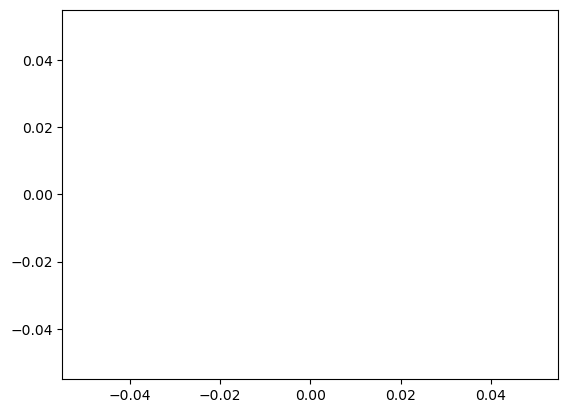

In [35]:
plt.plot(losses[50:])

## RMSE and MAE 

In [36]:
def custom_unscale_tensor(scaled_tensor, Ymin, Ymax):
    # Unscale the tensor
    unscaled_tensor = scaled_tensor * (Ymax - Ymin) + Ymin
    return unscaled_tensor

In [38]:
Ymin = np.array([-4.827219, -4.670366, -1.61531, -4.827219, -4.670366, -1.33319, -1.708888, -4.641845, -0.996765, -2.395545, -3.538317, -0.610118, -0.73015, -0.458181, -0.618446, -0.547083, -0.635806, -0.890536, -0.472103, -1.45062, -0.681022, -0.99279, -1.011758, -1.162863, -0.907198, -1.96247, -1.076272, -1.329813, -0.362183, -2.537684, -1.283295, -0.654882, -0.914182, -1.96247, -1.331524, -0.871627, -1.922738, -2.229401, -0.779045, -0.981595, -0.4033, -0.987313, -0.703766, -0.472103, -0.542543, -1.090887, -0.822775, -0.979512, -1.107637, -1.414454])
Ymax = np.array([4.117475, 4.160087, 0.580029, 3.323006, 1.356171, 0.918294, 4.117475, 0.346073, 1.353984, 2.80548, 4.160087, 0.580029, 0.531605, 1.382308, 0.356522, 1.28978, 0.298985, 0.201593, 0.628052, 1.242294, 0.951346, 0.945927, 0.687809, 0.815839, 0.806334, 2.150131, 1.588754, 0.167812, 3.323006, 0.00258, 2.037522, 1.560715, 1.466992, 1.018785, 2.80548, 4.160087, 0.580029, 0.531605, 1.382308, 0.356522, 1.28978, 0.298985, 0.201593, 0.628052, 1.242294, 0.951346, 0.945927, 0.687809, 0.815839, 0.806334])

In [39]:
Ymin.shape, Ymax.shape

((50,), (50,))

In [40]:
Ymin = torch.tensor(Ymin, dtype=torch.float32)
Ymax = torch.tensor(Ymax, dtype=torch.float32)

In [41]:
Yscaled = torch.tensor(scaled_df.to_numpy(), dtype=torch.float32)

In [42]:
Yunscaled = Yscaled * (Ymax - Ymin).unsqueeze(0) + Ymin

In [43]:
Yunscaled

tensor([[-4.3141, -5.2568, -1.7652,  ..., -2.5144, -3.1571, -4.4818],
        [-4.7705, -5.1213, -1.7270,  ..., -2.4938, -3.1309, -4.4523],
        [-4.3862, -5.1053, -1.7461,  ..., -2.5124, -3.1623, -4.4798],
        ...,
        [-4.0537, -7.6739, -3.4575,  ..., -0.7638, -0.9353, -1.8027],
        [-2.3310, -5.7293, -3.6388,  ..., -0.8235, -0.9719, -1.8612],
        [-2.0921, -5.5491, -3.7265,  ..., -0.8498, -0.9949, -1.8763]])

In [44]:
predictions = model(inputs)

In [45]:
unscaled_predictions = custom_unscale_tensor(predictions, Ymin, Ymax)

In [46]:
unscaled_targets = custom_unscale_tensor(outputs, Ymin, Ymax)

In [47]:
unscaled_predictions.shape, unscaled_targets.shape

(torch.Size([1697935, 50]), torch.Size([1697935, 50]))

In [48]:
mae = mean_absolute_error(unscaled_targets.detach().numpy(), unscaled_predictions.detach().numpy())
print(mae)
mse = mean_squared_error(unscaled_targets.detach().numpy(), unscaled_predictions.detach().numpy())
print(mse)
rmse = np.sqrt(mean_squared_error(unscaled_targets.detach().numpy(), unscaled_predictions.detach().numpy()))
print(rmse)

0.15933849
0.30808297
0.5550522


In [50]:
unscaled_predictions_at_index_0 = unscaled_predictions[0].squeeze()
unscaled_targets_at_index_0 = unscaled_targets[0].squeeze()

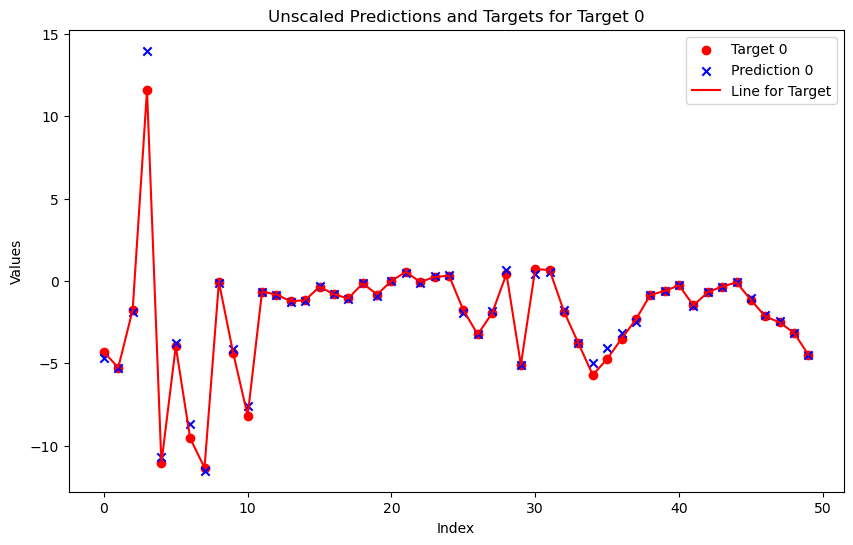

In [57]:
targets_to_plot = [0]

for target_idx in targets_to_plot:
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(unscaled_targets_at_index_0_np)), unscaled_targets_at_index_0_np, label=f'Target {target_idx}', color='red', marker='o')
    plt.scatter(range(len(unscaled_predictions_at_index_0_np)), unscaled_predictions_at_index_0_np, label=f'Prediction {target_idx}', color='blue', marker='x')
    plt.plot(range(len(unscaled_targets_at_index_0_np)), unscaled_targets_at_index_0_np, linestyle='-', color='red', label='Line for Target')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Unscaled Predictions and Targets for Target {target_idx}')

plt.show()

## Save Model

In [ ]:
torch.save(model.state_dict(), 'my_LTU_model_3.pth')

In [ ]:
# device = torch.device('cpu')
# print(device)
# to_device(model, device)

## Load

In [ ]:
model.load_state_dict(torch.load('my_LTU_model_3.pth'))

In [ ]:
model.eval()

## Save Scalers

In [ ]:
joblib.dump(inputscaler, 'inputscaler.pkl')
joblib.dump(custom_scale_dataframe, 'outputscaler.pkl')
joblib.dump(custom_unscale_tensor, 'custom_unscale_tensor.pkl')

In [ ]:
inputscaler = joblib.load('inputscaler.pkl')
custom_scale_dataframe = joblib.load('outputscaler.pkl')
custom_unscale_tensor = joblib.load('custom_unscale_tensor.pkl')

In [ ]:
loaded_data = inputscaler, custom_scale_dataframe, custom_unscale_tensor
print(loaded_data)